In [1]:
from compounds_research.compound.utils import plot_utilization_vs_rate, plot_raw_data,  plot_market_util, plot_market_rates, c_markets, make_rates_df, get_comp_market
from compounds_research.compound.fetch_compound import make_dataframe, token_addresses, variables
from compounds_research.utils import get_market

from compounds_research.aave import analyze_aave
from compounds_research.dydx import analyze_dydx

from compounds_research import settings
from matplotlib.lines import Line2D

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import time
import seaborn as sns

### Plotting style

In [2]:
plt.style.use('ggplot')
plt.rc('axes',edgecolor='darkgrey')
plt.rcParams["axes.linewidth"]  = 0.5

In [3]:
markets = {
    'dydx': ['dai', 'eth', 'usdc'],
    'compound': ['dai', 'eth', 'bat', 'zrx', 'usdc', 'sai', 'rep', 'wbtc'],
    'aave': ['LEND', 'LINK', 'DAI', 'USDC', 'WBTC', 'sUSD', 'KNC', 'USDT',
       'ETH', 'SNX', 'TUSD', 'MANA', 'BAT', 'MKR', 'BUSD', 'ZRX', 'REP']
}

all_markets = ['DAI', 'ETH', 'USDC', 'WBTC', 'BAT', 'ZRX', 'REP', 'SAI', 
               'LEND', 'LINK', 'USDT', 'KNC', 'SNX', 'TUSD', 'MANA', 'MKR', 'BUSD']

# prices: coinmarketcap, access: 22-05-2020
usd_markets = {
    'dai': 1,
    'eth': 203.01,
    'bat': 0.20329,
    'zrx': 0.33876,
    'sai': 1.09,
    'usdc': 1,
    'rep': 12.38,
    'wbtc': 9197.24,
    'lend': 0.057779,
    'link': 3.96,
    'knc': 0.634943,
    'usdt': 1,
    'mana': 0.036948,
    'mkr': 316.95,
    'busd': 1
}

## Data Exploration
This notebook examines a given market across the different lending platforms Aave, Compound and dYdX.

### Compute stats

In [14]:
def get_median_usd_funds_locked(platform: str, market: str):
    if platform == 'aave':
        return aave[(aave['Symbol'] == market.upper()) & (aave['Datetime'] <= '2020-05-07 00:00:00')]['Total Liquidity'].median() * usd_markets[market.lower()]
    elif platform == 'compound':
        df_comp = get_market(market.lower(), 'compound')
        return df_comp[df_comp.index <= '2020-05-07 00:00:00']['total_supply_history'].median() * usd_markets[market.lower()]
    elif platform == 'dydx':
        df_dydx = analyze_dydx.load_dydx_market(market.lower())
        return df_dydx[df_dydx.index <= '2020-05-07 00:00:00']['supply_amount'].median() * usd_markets[market.lower()]

### Methods (plotting)

In [ ]:
def plot_borrow_rates(market: str):
    lwidth = 0.8
    fsize = 10
    plt.figure(figsize=(12, 8))
    plt.ylabel('Interest Rate', fontdict={'size': fsize})
    if market in markets['compound']:
        df_comp = get_market(market.lower(), 'compound')
        plt.plot(df_comp['borrow_rates'], label='Compound', linewidth=lwidth, color='steelblue')
    if market.upper() in markets['aave']:
        plt.plot(aave[aave['Symbol'] == market.upper()]['Datetime'], aave[aave['Symbol'] == market.upper()]['Variable Borrow Rate'], label='Aave', linewidth=lwidth, color='tomato')
    if market in markets['dydx']:
        df_dydx = analyze_dydx.load_dydx_market(market.lower())
        plt.plot(df_dydx['interest_rate'], label='dYdX', linewidth=lwidth, color='lightseagreen')
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(color='whitesmoke')
    plt.title(market.capitalize()+': Borrow Interest Rates', fontdict={'size':fsize})
    plt.legend(fontsize=fsize)
    plt.show()
    

In [ ]:
def plot_liquidity(market: str, plot_aave=True, plot_comp=True, plot_dydx=True):
    lwidth = 1
    fsize = 10
    plt.figure(figsize=(12, 8))
    plt.ylabel(market.capitalize(), fontdict={'size': fsize})
    if plot_comp:
        df_comp = get_market(market.lower(), 'compound')
        plt.plot(df_comp['total_borrows_history'], label='Borrow', linewidth=lwidth, color='tomato')
        plt.plot(df_comp['total_supply_history'], label='Supply', linewidth=lwidth, color='steelblue')
        plt.fill_between(df_comp.index, df_comp['total_borrows_history'], df_comp['total_supply_history'], color='aliceblue')
        plt.legend()
    if plot_aave:
        plt.plot(aave[aave['Symbol'] == market.upper()]['Datetime'], aave[aave['Symbol'] == market.upper()]['Total Borrows'],  label='Borrow', linewidth=lwidth, color='tomato')
        plt.plot(aave[aave['Symbol'] == market.upper()]['Datetime'], aave[aave['Symbol'] == market.upper()]['Total Liquidity'], label='Supply', linewidth=lwidth, color='steelblue')
        plt.fill_between(aave[aave['Symbol'] == market.upper()]['Datetime'], aave[aave['Symbol'] == market.upper()]['Total Borrows'],aave[aave['Symbol'] == market.upper()]['Total Liquidity'], color='mistyrose')
    if plot_dydx:
        df_dydx = analyze_dydx.load_dydx_market(market.lower())
        plt.plot(df_dydx['borrow_amount'], label='Borrow', linewidth=lwidth, color='tomato')
        plt.plot(df_dydx['supply_amount'], label='Supply', linewidth=lwidth, color='steelblue')
        plt.fill_between(df_dydx.index, df_dydx['borrow_amount'], df_dydx['supply_amount'], color='peachpuff')
    plt.title('Liquidity', fontdict={'size':fsize})
    plt.yscale('log')
    
    
    comp_patch = mpatches.Patch(color='aliceblue', label='Compound')
    aave_patch = mpatches.Patch(color='mistyrose', label='Aave')
    dydx_patch = mpatches.Patch(color='peachpuff', label='dYdX')
    supply_line = Line2D([0], [0], color='steelblue', lw=2, label='Supply')
    borrows_line = Line2D([0], [0], color='tomato', lw=2, label='Borrows')
    plt.legend(handles=[supply_line, borrows_line, comp_patch, aave_patch, dydx_patch], prop={'size':fsize}, handlelength=3)
    
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(color='whitesmoke')
    plt.show()


In [ ]:
def plot_liquidity_util(market: str, plot_aave=False, plot_comp=False, plot_dydx=False):
    lwidth = 0.8
    fsize = 10
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_ylabel(market.capitalize(), fontdict={'size': fsize})
    ax2.set_ylabel('Utilization', fontdict={'size': fsize})
    
    if plot_comp:
        df_comp = get_market(market.lower(), 'compound')
        ax1.plot(df_comp['total_borrows_history'], label='Borrow', linewidth=lwidth, color='tomato')
        ax1.plot(df_comp['total_supply_history'], label='Supply', linewidth=lwidth, color='steelblue')
        ax2.plot(df_comp['utilization_ratio'], label='Utilization', linewidth=lwidth, linestyle='--', color='dodgerblue')
       
    elif plot_aave:
        ax1.plot(aave[aave['Symbol'] == market.upper()]['Datetime'], aave[aave['Symbol'] == market.upper()]['Total Borrows'],  label='Borrow', linewidth=lwidth, color='tomato')
        ax1.plot(aave[aave['Symbol'] == market.upper()]['Datetime'], aave[aave['Symbol'] == market.upper()]['Total Liquidity'], label='Supply', linewidth=lwidth, color='steelblue')
        ax2.plot(aave[aave['Symbol'] == market.upper()]['Datetime'], aave[aave['Symbol'] == market.upper()]['Utilization Rate'], label='Utilization', linewidth=lwidth, linestyle='--', color='dodgerblue')
    elif plot_dydx:
        df_dydx = analyze_dydx.load_dydx_market(market.lower())
        ax1.plot(df_dydx['borrow_amount'], label='Borrow', linewidth=lwidth, color='tomato')
        ax1.plot(df_dydx['supply_amount'], label='Supply', linewidth=lwidth, color='steelblue')
        ax2.plot(df_dydx['utilization'], label=market, linewidth=lwidth, linestyle='--', color='dodgerblue')

#     comp_patch = mpatches.Patch(color='aliceblue', label='Compound')
#     aave_patch = mpatches.Patch(color='mistyrose', label='Aave')
#     dydx_patch = mpatches.Patch(color='peachpuff', label='dYdX')
#     supply_line = Line2D([0], [0], color='steelblue', lw=2, label='Supply')
#     borrows_line = Line2D([0], [0], color='tomato', lw=2, label='Borrows')
#     plt.legend(handles=[supply_line, borrows_line, comp_patch, aave_patch, dydx_patch], prop={'size':fsize}, handlelength=3)
    
    ax1.set_facecolor('white')
    ax1.grid(color='whitesmoke')
    plt.show()


In [ ]:
plot_liquidity_util('dai', plot_comp=True)
plot_liquidity_util('dai', plot_aave=True)
plot_liquidity_util('dai', plot_dydx=True)

In [ ]:
def plot_utilization(market: str, plot_aave=True, plot_comp=True, plot_dydx=True):
    lwidth = 0.8
    fsize = 10
    plt.figure(figsize=(12, 8))
    plt.ylabel('Utilization', fontdict={'size': fsize})
    if plot_comp and market in markets['compound']:
        df_comp = get_market(market.lower(), 'compound')
        plt.plot(df_comp['utilization_ratio'], label='Compound', linewidth=lwidth, color='steelblue')
    if plot_aave and market.upper() in markets['aave']:
        plt.plot(aave[aave['Symbol'] == market.upper()]['Datetime'], aave[aave['Symbol'] == market.upper()]['Utilization Rate'], label='Aave', linewidth=lwidth, color='slategrey')
    if plot_dydx and market in markets['dydx']:
        df_dydx = analyze_dydx.load_dydx_market(market.lower())
        plt.plot(df_dydx['utilization'], label='dYdX', linewidth=lwidth, color='lightcoral')
    plt.legend(fontsize=fsize)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(color='whitesmoke')
    plt.title(market.capitalize(), fontdict={'size': fsize})
    plt.show()
    
def plot_utilization_per_platform(platform: str):
    lwidth = 1
    fsize = 10
    plt.figure(figsize=(12, 8))
    for market in markets[platform]:
        if platform == 'compound':
            df_comp = get_market(market.lower(), 'compound')
            plt.plot(df_comp['utilization_ratio'], label=market, linewidth=lwidth)
        elif platform == 'aave':
            plt.plot(aave[aave['Currency'] == market.upper()]['Datetime'], aave[aave['Currency'] == market.upper()]['Utilization Rate'], label=market, linewidth=lwidth)
        elif platform == 'dydx':
            df_dydx = analyze_dydx.load_dydx_market(market.lower())
            plt.plot(df_dydx['utilization'], label=market, linewidth=lwidth)
        else:
            print('invalid platform: ', platform)
            return
    plt.ylabel('Utilization', fontdict={'size': fsize})
    plt.legend(fontsize=fsize)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(color='whitesmoke')
    plt.title(platform.capitalize(), fontdict={'size': fsize})
    plt.show()
    

In [ ]:
msize=2.5
fsize=6

# plot: all markets per platform: show median locked funds, avg. utilization, avg. borrow rate
def plot_market_summaries():
    fig = plt.figure(figsize=(1*3.57072,1*2))
    gs = matplotlib.gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.22)
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[0,0], sharex=ax1)

    # plot for aave
    for market in all_markets:
        if market.upper() not in markets['aave']:
            continue
        ax1.plot(market, aave[aave['Symbol'] == market.upper()]['Utilization Rate'].mean(), 'r', marker='x', markersize=msize)
        ax2.plot(market, aave[aave['Symbol'] == market.upper()]['Variable Borrow Rate'].mean(), 'ro', markersize=msize)
        
    # plot for dydx
    for market in all_markets:
        if market.lower() not in markets['dydx']:
            continue
        dydx_df = analyze_dydx.load_dydx_market(market.lower())
        ax1.plot(market, dydx_df['utilization'].mean(), 'o', marker='x', color='dodgerblue', markersize=msize)
        ax2.plot(market,dydx_df['interest_rate'].mean(), 'o', color='dodgerblue', markersize=msize)
        
    # plot for compound
    for market in all_markets:
        if market.lower() not in markets['compound']:
            continue
        comp_df = get_market(market.lower(), 'compound')
        ax1.plot(market, comp_df['utilization_ratio'].mean(), 'o', marker='x', color='slategrey', markersize=msize)
        ax2.plot(market,comp_df['borrow_rates'].mean(), 'o', color='slategrey', markersize=msize)
        
    ax1.set_ylabel('Avg.\n Utilization', fontdict={'size':fsize})
    ax1.set_ylim(0,1)
    plt.setp(ax2.get_xticklabels(), visible=False)
    #plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.tick_params(axis='x', labelrotation=90)
    ax2.set_ylabel('Avg.\n Borrow Rate', fontdict={'size':fsize})
    ax2.legend()
    
    custom_lines = [Line2D([0], [0], color='r', lw=3),
                Line2D([0], [0], color='dodgerblue', lw=3),
                Line2D([0], [0], color='slategrey', lw=3)]

    ax2.legend(custom_lines, ['Aave', 'dYdX', 'Compound'], fontsize=fsize)
    ax2.set_ylim(0,0.3)
    ax1.set_facecolor('white')
    ax1.grid(color='whitesmoke')
    ax2.set_facecolor('white')
    ax2.grid(color='whitesmoke')
    ax1.yaxis.get_offset_text().set_fontsize(4)
    ax1.tick_params(axis='both', which='major', labelsize=fsize, width=0.25)
    ax1.tick_params(axis='both', which='minor', labelsize=fsize)
    ax2.tick_params(axis='both', which='major', labelsize=fsize, width=0.25)
    ax2.tick_params(axis='both', which='minor', labelsize=fsize)
    plt.savefig('platforms.pdf', dpi=900)

In [ ]:
plot_market_summaries()

### Interest rates and utilization

In [ ]:
# intersecting markets for Compound, Aave and dYdX
for market in list(set(markets['compound']) & set(markets['dydx']) & set(map(lambda m: m.lower(), markets['aave']))):
    plot_borrow_rates(market)

### Liquidity and illiquidity

In [ ]:
plot_liquidity('dai')

In [ ]:
plot_liquidity('eth')

In [ ]:
plot_liquidity('usdc')

### Platform utilization

In [ ]:
plot_utilization_per_platform('compound')
plot_utilization_per_platform('aave')
plot_utilization_per_platform('dydx')

### Cross-platform utilization 

In [ ]:
# intersecting markets for Compound, Aave and dYdX
for market in list(set(markets['compound']) & set(markets['dydx']) & set(map(lambda m: m.lower(), markets['aave']))):
    plot_utilization(market)

In [ ]:
lwidth=0.3
fsize=6
#comp_df[comp_df['utilization_ratio'] >= 1]['utilization_ratio'].plot(style='o', markersize=3)
comp_df[(comp_df.index > '2019-11-19 00:00:00') & (comp_df.index < '2020-05-07 00:00:00')]['borrow_rates'].plot(linewidth=lwidth, label='Compound')
#plt.plot(comp_df[(comp_df.index > '2019-11-19 00:00:00') & (comp_df.index < '2020-04-01 00:00:00')]['supply_rates'])
plt.plot(dydx_dai[(dydx_dai.index > '2019-11-19 00:00:00') & (dydx_dai.index < '2020-05-07 00:00:00')]['interest_rate'], linewidth=lwidth, label='dYdX')
#plt.plot(dydx_dai[(dydx_dai.index > '2019-11-19 00:00:00') & (dydx_dai.index < '2020-04-01 00:00:00')]['supply_rate'], 'o', markersize=3)
plt.plot(aave[(aave['Symbol'] == 'DAI') & (aave['Datetime'] > '2019-12-19 00:00:00') & (aave['Datetime'] < '2020-05-07 00:00:00')]['Variable Borrow Rate'], linewidth=lwidth, label='Aave')
plt.ylabel('Borrow Rate', fontdict={'size': 6})
plt.xlabel('')
plt.xticks(rotation=0)
#plt.legend()
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color='whitesmoke')
ax.yaxis.get_offset_text().set_fontsize(fsize)
ax.tick_params(axis='both', which='major', labelsize=fsize, width=0.25)
ax.tick_params(axis='both', which='minor', labelsize=fsize)
comp_patch = mpatches.Patch(color='mistyrose', label='Compound')
aave_patch = mpatches.Patch(color='mediumpurple', label='Aave')
dydx_patch = mpatches.Patch(color='steelblue', label='dYdX')
plt.legend(handles=[comp_patch, aave_patch, dydx_patch], prop={'size':fsize}, handlelength=3)

### Liquidity plot
**Note**: This takes a bit to run.

In [7]:
lwidth=0.8
fsize=6 
end_date = '2020-05-07 00:00:00'
pad=1.15

def plot_illiquidity(market: str):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    months_fmt = mdates.DateFormatter('%b\n%Y')      
    
    dydx_df = analyze_dydx.load_dydx_market(market.lower())
    comp_df = get_market(market.lower(), 'compound')
    dydf_df = dydx_df[dydx_df.index <= end_date]
    comp_df = comp_df[comp_df.index <= end_date]
    aave_df = analyze_aave.load_data()
    aave_df = aave_df[(aave_df['Datetime'] <= end_date) & (aave_df['Symbol'] == market.upper())]
    
    fig = plt.figure(figsize=(1*3.57072,1*2.95))
    gs = matplotlib.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[1, 1, 1], hspace=0.23)
    ax1 = fig.add_subplot(gs[2,0])
    ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
    ax3 = fig.add_subplot(gs[0,0], sharex=ax1)


    ax1.plot(comp_df['utilization_ratio'], linewidth=lwidth, color='dodgerblue')
    ax1.plot(comp_df['borrow_rates'], linewidth=lwidth, color='cornflowerblue', linestyle='dotted')
    ax1.set_title('Compound: Dai', loc='left', fontdict={'size': fsize}, pad=pad)

    ax2.plot(dydx_df['utilization'], linewidth=lwidth, color='dodgerblue', label='Utilization')
    ax2.plot(dydx_df['interest_rate'], linewidth=lwidth, color='cornflowerblue', linestyle='dotted', label='Borrow rate')
    ax2.set_title('dYdX: Dai', loc='left', fontdict={'size': fsize}, pad=pad)

    ax3.plot(aave_df['Datetime'], aave_df['Utilization Rate'], linewidth=lwidth, color='dodgerblue', label='Utilization')
    ax3.plot(aave_df['Datetime'], aave_df['Variable Borrow Rate'], linewidth=lwidth, color='cornflowerblue', linestyle='dotted', label='Borrow rate')
    ax3.set_title('Aave: Dai', loc='left', fontdict={'size': fsize}, pad=pad)
    
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)

    ax1.set_facecolor('white')
    ax2.set_facecolor('white')
    ax3.set_facecolor('white')
    
    
    for ax in [ax1, ax2, ax3]:
        ax.yaxis.get_offset_text().set_fontsize(fsize)
        ax.tick_params(axis='both', which='major', labelsize=fsize, width=0.25)
        ax.tick_params(axis='both', which='minor', labelsize=fsize)
    for xc in comp_df[comp_df['utilization_ratio'] >= 1].index:
        ax1.axvline(x=xc, color='lightcoral', alpha=0.3, zorder=1)
    for xc in dydx_df[dydx_df['utilization'] >= 1].index:
        ax2.axvline(x=xc, color='lightcoral', alpha=0.3, zorder=1)
    for xc in aave_df[aave_df['Utilization Rate'] >= 1].index:
        ax3.axvline(x=xc, color='lightcoral', alpha=0.3, zorder=1)

        
    # format the ticks
    ax1.xaxis.set_major_locator(months)
    ax1.xaxis.set_major_formatter(months_fmt)
    ax1.xaxis.set_minor_locator(months)

    # round to nearest days.
    datemin = np.datetime64(comp_df.index[0], 'D')
    datemax = np.datetime64(comp_df.index[-1], 'D') + np.timedelta64(1, 'D')
    ax1.set_xlim(datemin, datemax)

    # format the coords message box
    ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax1.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    
    # legend formatting
    ax3.legend(loc='upper center', prop={'size': fsize},bbox_to_anchor=(0.5, 1.33),
            ncol=3, fancybox=True, shadow=False)

    #plt.savefig('../../../Papers/5e6bad2e6490390001d3c466/images/dai-plfs-illiquidity.pdf', bbox_inches='tight', dpi=300)
    plt.savefig('../../../Papers/5e6bad2e6490390001d3c466/images/dai-plfs-illiquidity.png', bbox_inches='tight', dpi=300)


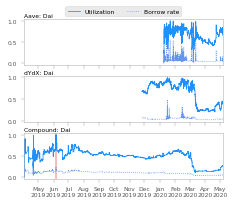

In [10]:
plot_illiquidity('usdc')

### Illiqudity plot
**Note**: dydx bottleneck, takes long. 

In [12]:
lwidth=0.8
fsize=6 
end_date = '2020-05-07 00:00:00'
pad=1

def plot_liquidity_market(market: str):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    months_fmt = mdates.DateFormatter('%b\n%Y')      
    
    dydx_df = analyze_dydx.load_dydx_market(market.lower())
    comp_df = get_market(market.lower(), 'compound')
    dydf_df = dydx_df[dydx_df.index <= end_date]
    comp_df = comp_df[comp_df.index <= end_date]
    aave_df = analyze_aave.load_data()
    aave_df = aave_df[(aave_df['Datetime'] <= end_date) & (aave_df['Symbol'] == market.upper())]
        
    fig = plt.figure(figsize=(1*3.57072,1*2.85))
    gs = matplotlib.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[1, 1, 1], hspace=0.23)
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[0,0], sharex=ax1)
    ax3 = fig.add_subplot(gs[2,0], sharex=ax1)

    ax1.plot(aave_df['Datetime'], aave_df['Total Borrows'], linewidth=lwidth, color='darkorange', label='Total Borrows')
    ax1.plot(aave_df['Datetime'], aave_df['Total Liquidity'], linewidth=lwidth, color='steelblue', label='Total Supply')
    ax1.fill_between(aave_df['Datetime'], aave_df['Total Borrows'], aave_df['Total Liquidity'], color='aliceblue')
    #ax1.set_title('Aave: Dai', loc='left', fontdict={'size': fsize}, pad=pad)
    
    ax3.plot(comp_df['total_borrows_history'], linewidth=lwidth, color='darkorange', label='Total Borrows')
    ax3.plot(comp_df['total_supply_history'], linewidth=lwidth, color='cornflowerblue')
    ax3.fill_between(comp_df.index, comp_df['total_borrows_history'], comp_df['total_supply_history'], color='aliceblue')
    #ax3.set_title('Compound: Dai', loc='left', fontdict={'size': fsize}, pad=pad)

    ax2.plot(dydx_df['borrow_amount'], linewidth=lwidth, color='darkorange', label='Total Borrows')
    ax2.plot(dydx_df['supply_amount'], linewidth=lwidth, color='cornflowerblue', label='Total Supply')
    ax2.fill_between(dydx_df.index, dydx_df['borrow_amount'], dydx_df['supply_amount'], color='aliceblue')
    #ax2.set_title('dYdX: Dai', loc='left', fontdict={'size': fsize}, pad=pad)

    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax1.get_xticklabels(), visible=False)

    ax1.set_ylabel('Aave\n'+market.upper(), fontdict={'size': fsize})
    ax2.set_ylabel('dYdX\n'+market.upper(), fontdict={'size': fsize})
    ax3.set_ylabel('Compound\n'+market.upper(), fontdict={'size': fsize})

    ax1.set_facecolor('white')
    ax2.set_facecolor('white')
    ax3.set_facecolor('white')

    for ax in [ax1, ax2, ax3]:
        ax.yaxis.get_offset_text().set_fontsize(fsize)
        ax.tick_params(axis='both', which='major', labelsize=fsize, width=0.24)
        ax.tick_params(axis='both', which='minor', labelsize=fsize)
    
    start_time = time.time()
    
    comp_df_89 = comp_df[(comp_df['utilization_ratio'] >= 0.8) & (comp_df['utilization_ratio'] < 0.9)]
    comp_df_9 = comp_df[(comp_df['utilization_ratio'] >= 0.9)]
    for xc in comp_df_89.index:
        ax3.axvline(x=xc, color='mistyrose', alpha=1, zorder=1)
    for xc in comp_df_9.index:
        ax3.axvline(x=xc, color='salmon', alpha=1, zorder=1)
    del comp_df_89
    del comp_df_9
    
    print('Compound time: ', time.time() - start_time)
    dydx_start = time.time()
    
    dydx_df_89 = dydx_df[(dydx_df['utilization'] >= 0.8) & (dydx_df['utilization'] < 0.9)]
    dydx_df_9 = dydx_df[(dydx_df['utilization'] >= 0.9)]

    for xc in dydx_df_89.index:
        ax2.axvline(x=xc, color='mistyrose', alpha=1, zorder=1)
    for xc in dydx_df_9.index:
        ax2.axvline(x=xc, color='salmon', alpha=1, zorder=1)
       
    print('dYdX time: ', time.time() - dydx_start)
    del dydx_df_89
    del dydx_df_9

    aave_start = time.time()
    
    aave_df_89 = aave_df[(aave_df['Utilization Rate'] >= 0.8) & (aave_df['Utilization Rate'] < 0.9)]
    aave_df_9 = aave_df[(aave_df['Utilization Rate'] >= 0.9)]
    for xc in aave_df_89['Datetime']:
        ax1.axvline(x=xc, color='mistyrose', alpha=1, zorder=1)
    for xc in aave_df_9['Datetime']:
        ax1.axvline(x=xc, color='salmon', alpha=1, zorder=1)
    
    del aave_df_89
    del aave_df_9

    print('Aave time: ', time.time() - aave_start)

    # format the ticks
    ax3.xaxis.set_major_locator(months)
    ax3.xaxis.set_major_formatter(months_fmt)
    ax3.xaxis.set_minor_locator(months)

    # round to nearest days.
    datemin = np.datetime64(comp_df.index[0], 'D')
    datemax = np.datetime64(comp_df.index[-1], 'D') + np.timedelta64(1, 'D')
    ax3.set_xlim(datemin, datemax)
    # format the coords message box
    ax3.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax3.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    
    # legend formatting 
    ax2.legend(loc='upper center', prop={'size': fsize},bbox_to_anchor=(0.5, 1.38),
            ncol=3, fancybox=True, shadow=False)
    
    plt.savefig('../../../Papers/5e6bad2e6490390001d3c466/images/'+market.lower()+'-plf-liquidity.png', bbox_inches='tight', dpi=300)


In [ ]:
plot_liquidity_market('dai')

Compound time:  0.16437029838562012
dYdX time:  288.443749666214
Aave time:  0.7279636859893799


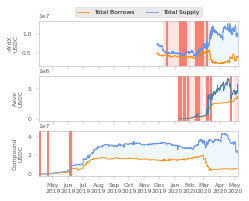

In [13]:
plot_liquidity_market('usdc')

Compound time:  0.0021119117736816406
dYdX time:  0.004385709762573242
Aave time:  0.0018968582153320312


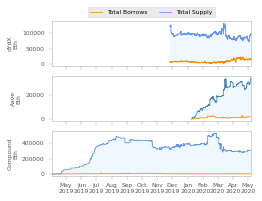

In [8]:
plot_liquidity_market('eth')